# Домашнее задание №1

- Кишмария Ника Гочевич
- Группа: MADE-DS-31

In [13]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
from tqdm import tqdm
import gym


In [14]:
%load_ext autoreload
%autoreload 2

from blackjack_double import BlackjackDoubleEnv
from blackjack_double_counting import BlackjackDoubleCountingEnv
from blackjack_double_counting_split import BlackjackDoubleCountingSplitEnv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:

- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
    - hit  — взять ещё одну карту;
    - stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [15]:
def play_game(env, pi):
    observation = env.reset()
    done = False
    G = 0
    while not done:
        action = pi[s2idx[observation]]
        observation, reward, done, _ = env.step(action)
        G += reward
    return G

def evaluate_pi(env, pi, n=100_000, disable_tqdm=False):
    rewards = []
    for _ in tqdm(range(n), disable=disable_tqdm):
        reward = play_game(env, pi)
        rewards.append(reward)
    return np.mean(rewards)

def get_pi_by_Q(Q):
    return np.argmax(Q, axis=1)

def Q_learning_episode(env, Q, A, alpha=0.05, epsilon=0.1, gamma=1):
    s = s2idx[env.reset()]
    done = False
    get_actions_from_env = hasattr(env, 'get_actions')
        
    while not done:
        pi = get_pi_by_Q(Q)
        a = pi[s] if random.random() < (1 - epsilon) else random.choice(env.get_actions() if get_actions_from_env else A)
        observation, r_new, done, _ = env.step(a)
        s_new = s2idx[observation]
        Q[s, a] = Q[s, a] + alpha * (r_new + gamma * max(Q[s_new]) - Q[s, a])
        s = s_new
    return Q

def Q_learning(env, A, Q, episodes=100_000, alpha=0.009, epsilon=0.85, gamma=1, disable_tqdm=False):
    for _ in tqdm(range(episodes), disable=disable_tqdm):
        Q = Q_learning_episode(env=env, Q=Q, A=A, alpha=alpha, epsilon=epsilon, gamma=gamma)
        
    return Q
        

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def plot_learinig(env, A, alpha, epsilon, episodes=1000, n_experiments=50, n_eval=100):

    Q_arr = [np.zeros((len(S), len(A)))] * n_experiments
    pi_arr = [get_pi_by_Q(Q) for Q in Q_arr]
    results = []

    episode_results = []
    episode_nums = []

    for episode in tqdm(range(episodes)):
        experiments_result = []
        for i in range(n_experiments):
            Q_arr[i] = Q_learning_episode(env, Q_arr[i], A, alpha=alpha, epsilon=epsilon)
            pi_arr[i] = get_pi_by_Q(Q_arr[i])
            experiments_result.append(evaluate_pi(env, pi_arr[i], n=n_eval, disable_tqdm=True))

        episode_results.append(np.mean(experiments_result))
        episode_nums.append(episode)

    plt.figure(figsize=(16, 8))
    plt.plot(episode_nums, episode_results, linewidth=1)
    plt.xlabel('Число эпизодов обучения')
    plt.ylabel('Награда')
    print(f'Награда каждого эпизода усреднена по {n_experiments} экспериментам и посчитана на {n_eval} раздачах. Всего {episodes} эпизодов')
    plt.show()

In [16]:
env = gym.make('Blackjack-v1')
env.natural = True

A = (0, 1)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [17]:
pi_dummy = [int(state[0] not in {19, 20, 21}) for state, idx in s2idx.items()]

In [18]:
reward_mean = evaluate_pi(env, pi_dummy, n=500_000)
print(f'Оценка выигрыша при стратегии "19-20-21": {reward_mean:.5f}')

100%|███████████████████████████████████████████████████████████████████████| 500000/500000 [00:34<00:00, 14403.04it/s]

Оценка выигрыша при стратегии "19-20-21": -0.19730


In [19]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.02, epsilon=0.1)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=500_000)
print(f'Оценка выигрыша при стратегии, обученной с помощью Q-обучения: {reward_mean:.5f}')

100%|███████████████████████████████████████████████████████████████████████| 500000/500000 [00:36<00:00, 13693.35it/s]


Оценка выигрыша при стратегии, обученной с помощью Q-обучения: -0.18278


**Попробуем подобрать параметры alpha и epsilon.**   
Перебирать все - это очень долго, поэтому буду подбирать epsilon при фиксированном alpha и наоборот.  
И так прогнать 2-3 итераций. Должно сойтись.

Забавно, что случайное блуждание при обучении выгоднее, чем следование стратегии. Думаю, это потому, что игры короткиe и  действий мало.

In [22]:
#При alpha=0.00005 и epsilon=0.95 достигаюся лучшие результаты

Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.00005, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=500_000)
print(f'Оценка выигрыша при стратегии, обученной с помощью Q-обучения: {reward_mean:.5f}')

100%|███████████████████████████████████████████████████████████████████████| 500000/500000 [00:35<00:00, 14256.82it/s]


Оценка выигрыша при стратегии, обученной с помощью Q-обучения: -0.04829


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:16<00:00,  3.16it/s]

Награда каждого эпизода усреднена по 50 экспериментам и посчитана на 100 раздачах. Всего 1000 эпизодов


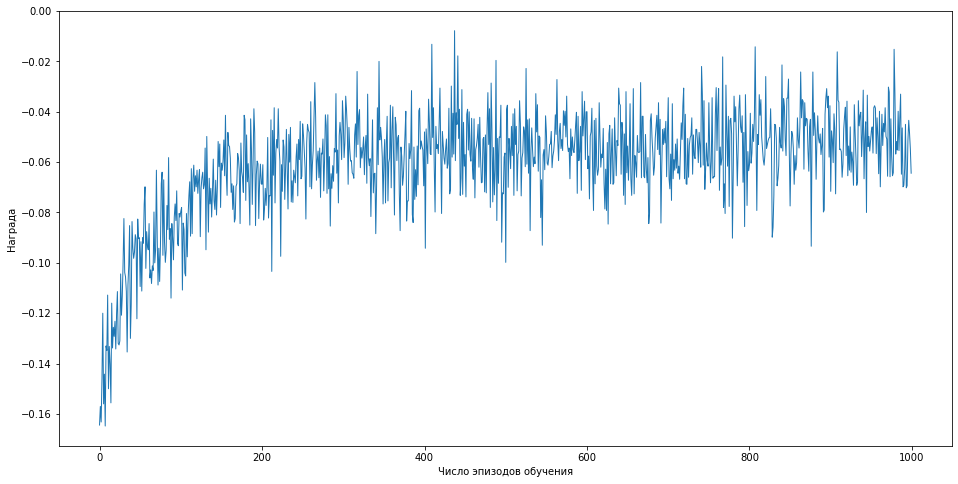

In [23]:
plot_learinig(env, A, alpha=0.00005, epsilon=0.95)

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
- Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [24]:
env = BlackjackDoubleEnv(natural=True)
A = (0, 1, 2)

S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [25]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.00005, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi)

print(f'Оценка выигрыша в варианте с double при стратегии, обученной с помощью Q-обучения: {reward_mean:.5f}')

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:06<00:00, 14551.86it/s]

Оценка выигрыша в варианте с double при стратегии, обученной с помощью Q-обучения: -0.02884


**Попробуем снова подобрать новую alpha и epsilon**

In [28]:
#При alpha=0.0002 и epsilon=0.95 достигаюся лучшие результаты

Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.0002, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi)

print(f'Оценка выигрыша в варианте с double при стратегии, обученной с помощью Q-обучения: {reward_mean:.5f}')

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:06<00:00, 14391.47it/s]

Оценка выигрыша в варианте с double при стратегии, обученной с помощью Q-обучения: -0.02780


Мы уже довольно близко :)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:14<00:00,  3.17it/s]

Награда каждого эпизода усреднена по 50 экспериментам и посчитана на 100 раздачах. Всего 1000 эпизодов


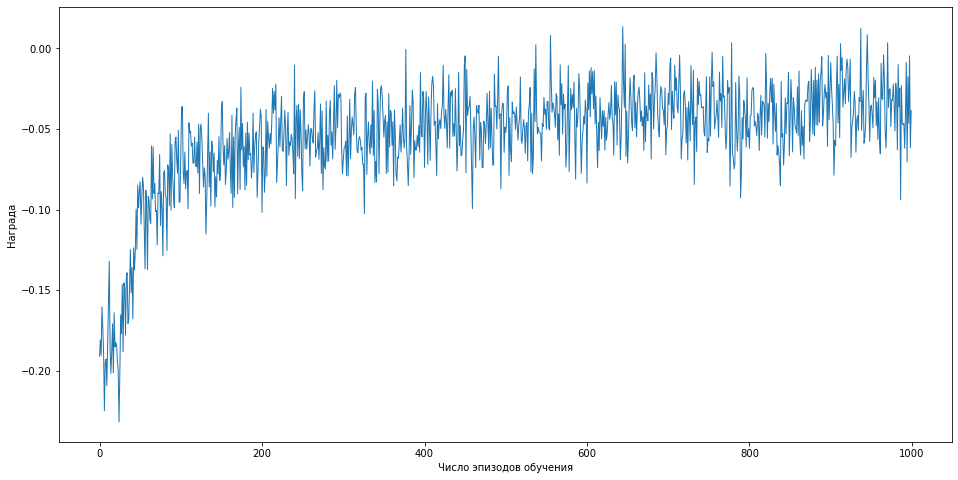

In [29]:
plot_learinig(env, A, alpha=0.0002, epsilon=0.95)

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.
- Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.



----------------------

Будем считать карты по системе «Половинки» из статьи https://ru.wikipedia.org/wiki/Блэкджек#Отслеживание_карт

- Считаем карты игрока сразу после получения
- Считаем после раздачи только 1-ю карту диллера
- После того, как открываются карты, считаем остальные карты диллера
- Если перед началом игры карт остается меньше 15, собираем новую колоду
- Всего очков по системе «Половинки» может быть от -44 до 44 (я округлил до целых, умножив на 2)

In [30]:
env = BlackjackDoubleCountingEnv(natural=True)
A = (0, 1, 2)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False), range(-44, 45)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

Состояний получается в 89 раз больше. Попробуем взять хотя бы в 5 раз больше эпизодов для обучения

In [31]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=500_000, alpha=0.0002, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=500_000)

print(f'Оценка выигрыша в варианте с double и подсчетом карт при стратегии, обученной с помощью Q-обучения : {reward_mean:.5f}')

100%|███████████████████████████████████████████████████████████████████████| 500000/500000 [00:36<00:00, 13617.55it/s]

Оценка выигрыша в варианте с double и подсчетом карт при стратегии, обученной с помощью Q-обучения : 0.01860


### Мы вроде обыграли казино! :)


In [34]:
#При alpha=0.00002 и epsilon=1 достигаюся лучшие результаты
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=500_000, alpha=0.00002, epsilon=1)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=500_000)

print(f'Оценка выигрыша в варианте с double и подсчетом карт при стратегии, обученной с помощью Q-обучения : {reward_mean:.5f}')

100%|███████████████████████████████████████████████████████████████████████| 500000/500000 [00:40<00:00, 12215.03it/s]

Оценка выигрыша в варианте с double и подсчетом карт при стратегии, обученной с помощью Q-обучения : 0.01192


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:52<00:00,  2.83it/s]

Награда каждого эпизода усреднена по 50 экспериментам и посчитана на 100 раздачах. Всего 1000 эпизодов


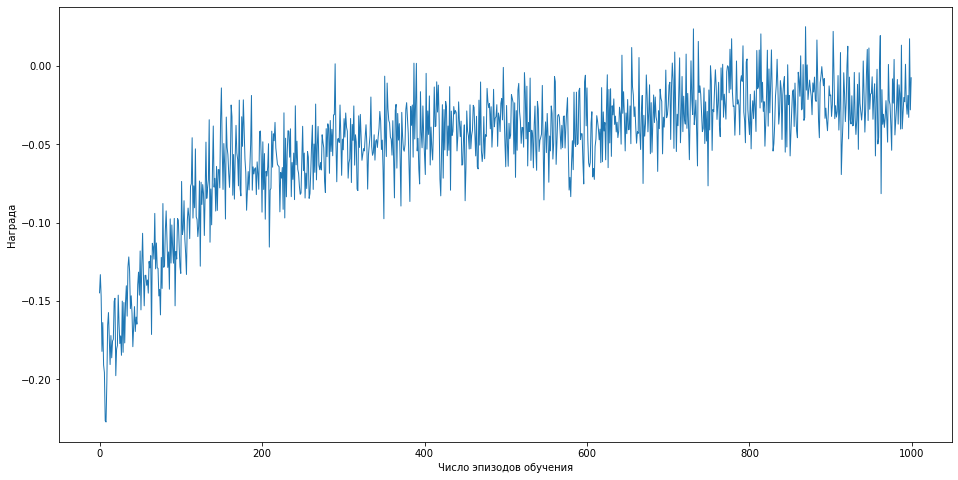

In [35]:
plot_learinig(env, A, alpha=0.00002, epsilon=1)